In [1]:
import os
import sys
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import shutil

sys.path.insert(0, os.path.join("..", "..", ".."))

from petroflow import Well, WellBatch, WS, WellDataset
from petroflow.batchflow.models.torch import UNet, ResNet18, ResNet34
from petroflow.batchflow import Dataset, DatasetIndex, FilesIndex, Pipeline, V, B, action, inbatch_parallel, I, W, F, L, ImagesBatch, R, P

Auxilary functions/classes

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

class MyWellBatch(WellBatch):    
    @action
    def create_images_batch(self, core_dl, core_uv, targets):
        index = DatasetIndex(len(core_dl))
        batch = ImagesBatch(index)
        batch = batch.add_components(('core_dl', 'core_uv', 'targets'),
                                     (np.array(core_dl).astype(np.uint8),
                                      np.array(core_uv).astype(np.uint8),
                                      np.array(targets)))
        return batch

class softCrossEntropy(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        self.weights = weights
        return

    def forward(self, inputs, target):
        """
        :param inputs: predictions
        :param target: target labels
        :return: loss
        """
        log_likelihood = - F.log_softmax(inputs, dim=1)
        if self.weights:
            log_likelihood *= self.weights
        sample_num, class_num = target.shape
        loss = torch.sum(torch.mul(log_likelihood, target)) / sample_num

        return loss

def mydump(iteration):
    import pickle
    with open('flag', 'wb') as f:
        pickle.dump(iteration, f)

Constants

In [3]:
BATCH_SIZE = 32
N_CROPS = 16
N_EPOCH = 500
LENGTH = 10
SHAPE = (6, int(25 * LENGTH), 250)

CLASSES = ['GRAVEL', 'SAND', 'ALEURITE', 'PELITE']

Filter wells without grain table

In [4]:
index = FilesIndex(path='/data/petro_data/data/core_images/core_photo_cm/*', dirs=True)
ds = Dataset(index=index, batch_class=MyWellBatch)

filter_ppl = (ds.p
              .init_variable('wells', default=[])
              .has_attr('core_properties')
              .update(V('wells', mode='e'), B().indices)
              .run(10, n_epochs=1, shuffle=False, bar=True))

filtered_index = index.create_subset(filter_ppl.v('wells'))
ds = Dataset(index=filtered_index, batch_class=MyWellBatch)
ds.split()

100%|██████████| 34/34 [00:00<00:00, 115.19it/s]


Compute weights for loss

In [5]:
# weights = pd.read_feather('/notebooks/data/september_dataset/grain.feather')[CLASSES].mean() / 100
# weights = 1 / weights
# weights = np.clip(weights, 0, 20)

In [6]:
(Well(path=ds.train.index.get_fullpath(ds.train.indices[0]))
        .create_segments(src='samples', connected=True)
        .create_segments(src='core_properties', length=2 * LENGTH)
        .crop(length=LENGTH, step=LENGTH).load_core().iter_level()[0].core_properties
       )

,FIELD,WELL,GRAVEL,SAND,ALEURITE,PELITE,LITHOLOGY,LOSS
DEPTH,,,,,,,,
379231,Тазовское,83_тазовское,0.0,72.407,17.594,9.999,песчаник алевролитистый слабо глинистый сла...,0.0


In [7]:
crops_template = (Pipeline()
    .create_segments(src='samples', connected=True)
    .create_segments(src='core_properties', length=2 * LENGTH)
    .random_crop(length=LENGTH, n_crops=N_CROPS)
    .drop_short_segments(LENGTH)
)

In [8]:
components_template = (Pipeline()
    .load_core(pixels_per_cm=25, core_width=10)
    .update(B('core'), (WS('core_dl').ravel(), WS('core_uv').ravel()))
    .update(B('targets'), WS('core_properties')[CLASSES].mean().values.ravel())
    .create_images_batch(B('core')[0], B('core')[1], B('targets'))
    .to_pil(src=['core_dl', 'core_uv'], dst=['core_dl', 'core_uv'])
)

augmentation_template = (Pipeline()
    .cutout(shape=P((R(np.arange(100, 200)), R(np.arange(100, 200)))),
            origin=P((R('uniform'), R('uniform'))),
            color=0, src=['core_dl', 'core_uv'], dst=['core_dl', 'core_uv'])
)

concat_template = (Pipeline()
    .add_namespace(np)
    .to_array(src=['core_dl', 'core_uv'], dst=['core_dl', 'core_uv'])
    .concatenate((B('core_dl'), B('core_uv')), axis=-1, save_to=B('crops'))
    .transpose(B('crops'), axes=(0, 3, 1, 2), save_to=B('crops'))
    .nan_to_num(B('crops'), save_to=B('crops'))
    .array(B('crops'), dtype='float32', save_to=B('crops'))
    .array(B('targets'), dtype='float32', save_to=B('targets'))
)

model_config = {'initial_block/inputs': 'images',
                'inputs/images/shape': SHAPE,
                'inputs/labels/classes': 4,
                'optimizer': 'Adam',#('SGD', dict(lr=0.01, momentum=0.95)),
                'device': 'gpu:1',
                'output': 'proba',
                'microbatch': N_CROPS,
                'loss': softCrossEntropy
               }
        
train_template = (Pipeline()
    .init_variable('loss_history', default=[])
    .init_model('dynamic', ResNet18, 'model', model_config)
    # .mydump(I())
    .train_model('model', B('crops'), B('targets') / 100, fetches='loss', save_to=V('loss_history', mode='a'))
    
)

In [9]:
ppl = (crops_template + 
       components_template +
       # augmentation_template @ 0.33 +
       concat_template +
       train_template
      ) << ds.train

In [10]:
(crops_template << ds.train).next_batch(BATCH_SIZE)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
#b = ppl.next_batch(16)
#b.crops.shape

In [12]:
# plt.figure(figsize=(10, 10))
# for i, crop in enumerate(np.array(b.crops_dl)):
#     plt.subplot(BATCH_SIZE, N_CROPS, i+1)
#     plt.title(("{:3.0f}, "*4)[:-2].format(*b.targets[i]))
#     plt.imshow(crop / 255)
#     plt.xticks([])
#     plt.yticks([])

In [13]:
# pd.read_feather('/notebooks/data/september_dataset/core_photo/Восточно-Мессояхское/123_восточно-мессояхское/grain.feather')

In [14]:
ppl.next_batch(BATCH_SIZE, n_epochs=N_EPOCH, bar=True, shuffle=True,
        drop_last=True, bar_desc=W(V('loss_history')[-1]))

1.6116436:   0%|          | 1/3000 [00:32<27:03:41, 32.48s/it]

In [15]:
import pickle
# ppl.get_model_by_name('model').save('model.torch')

with open('loss', 'wb') as f:
    pickle.dump(ppl.get_variable('loss_history'), f)

# with open('dataset', 'wb') as f:
#     pickle.dump(ds, f)

In [16]:
with open('loss', 'rb') as f:
    loss = pickle.load(f)

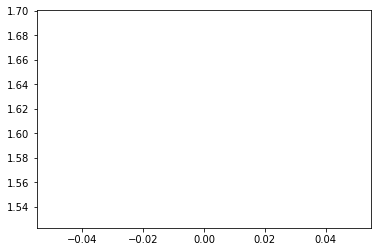

In [17]:
import pandas as pd
plt.plot(loss)
plt.plot(pd.Series(np.array(loss)).rolling(100).mean())

In [18]:
split_test = (Pipeline()
    .create_segments(src='samples', connected=True)
    .create_segments(src='core_properties', length=2 * LENGTH)
    .crop(length=LENGTH, step=LENGTH)
    .drop_short_segments(LENGTH)
    .init_variable('lithology', default=[])
    .update(V('lithology', mode='e'), WS('core_properties').iloc[0].ravel())
)


test_template = (Pipeline()
    .init_variable('predictions', default=[])
    .init_model('dynamic', ResNet18, 'model', config={
                    'device': 'cpu', 'load/path': 'model.torch'
                })
    .predict_model('model', B('crops'), fetches='proba', save_to=V('predictions', mode='e')) 
)

In [19]:
ppl = (split_test + components_template + concat_template + test_template) << ds.test
ppl.next_batch(1, n_epochs=1, bar=True)


  2%|▏         | 1/56 [00:11<10:48, 11.80s/it]

In [20]:
target = pd.concat(ppl.v('lithology'), axis=1).transpose()

In [21]:
values = np.array(ppl.v('predictions')) * 100
pred = pd.DataFrame({
    'GRAVEL_PRED': values[:, 0],
    'SAND_PRED': values[:, 1],
    'ALEURITE_PRED': values[:, 2],
    'CLAY_PRED': values[:, 3]
})

In [22]:
results = pd.concat([target.reset_index(), pred], axis=1)

In [23]:
results['LITHOLOGY'] = results.LITHOLOGY.apply(lambda x: x.split(' ')[0].capitalize())

In [24]:
results

,index,FIELD,WELL,GRAVEL,SAND,ALEURITE,PELITE,LITHOLOGY,LOSS,GRAVEL_PRED,SAND_PRED,ALEURITE_PRED,CLAY_PRED
0,87990,Восточно-Мессояхское,214_восточно-мессояхское,0,83.582,9.344,7.074,Песчаник,1.42109e-14,70.486794,2.773912,7.580011,19.159296
1,87990,Восточно-Мессояхское,214_восточно-мессояхское,0,83.582,9.344,7.074,Песчаник,1.42109e-14,71.633125,2.280627,7.268858,18.817387
2,88011,Восточно-Мессояхское,214_восточно-мессояхское,0,84.039,9.729,6.232,Песчаник,0,72.126488,2.292507,7.029078,18.551926
3,88011,Восточно-Мессояхское,214_восточно-мессояхское,0,84.039,9.729,6.232,Песчаник,0,72.562073,2.224367,6.825572,18.387991
4,88026,Восточно-Мессояхское,214_восточно-мессояхское,0,80.896,11.1,8.006,Песчаник,0,71.824959,2.311435,7.245140,18.618467
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,97639,Восточно-Мессояхское,214_восточно-мессояхское,0,56.682,26.329,16.99,Песчаник,0,34.787117,8.660498,30.043396,26.508993
192,98243,Восточно-Мессояхское,214_восточно-мессояхское,0,45.868,40.218,13.914,Песчаный,0,31.152445,18.516836,24.411850,25.918865
193,98243,Восточно-Мессояхское,214_восточно-мессояхское,0,45.868,40.218,13.914,Песчаный,0,42.366302,14.811688,24.309027,18.512981
194,98303,Восточно-Мессояхское,214_восточно-мессояхское,0,71.904,18.542,9.554,Песчаник,0,40.035595,13.332981,26.809238,19.822189


In [25]:
classes = ['Песчаник', 'Алевролит', 'Глина']
colors = ['r', 'g', 'b', 'y']

mask = [np.isin(item, classes) for item in results.LITHOLOGY]

In [26]:
# grain.columns[3:7]
from sklearn.manifold import TSNE
tsne_res = TSNE(n_components=2, n_iter_without_progress=500).fit_transform(results[
    ['GRAVEL_PRED', 'SAND_PRED', 'ALEURITE_PRED', 'CLAY_PRED']
])

([], <a list of 0 Text yticklabel objects>)

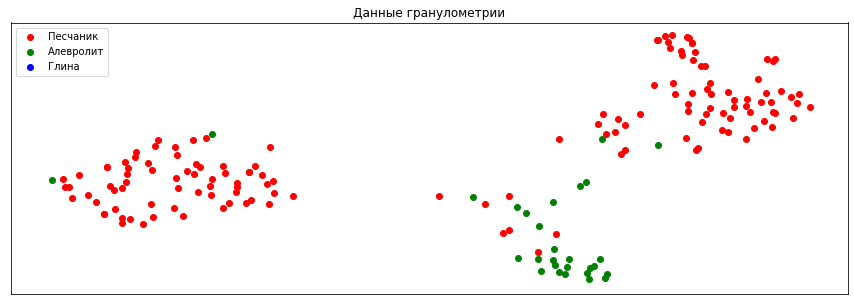

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

for label, color in zip(classes, colors):
    plt.scatter(tsne_res[(results.LITHOLOGY == label).values, 0],
                tsne_res[(results.LITHOLOGY == label).values, 1], color=color, label=label)

plt.title('Данные гранулометрии')
plt.legend()
plt.xticks([])
plt.yticks([])